In [79]:
import os
import random
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, LSTM
from keras.utils import plot_model
from reading_manager import read_csv
from keras.callbacks import EarlyStopping
from keras import regularizers
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

## Analyzing model applications - machine learning

In [80]:
# Set up the paths
IMAGES_PATH = "C:/Users/mjgoj/Documents/pressure_images"
RECORDINGS_PATH = "C:/Users/mjgoj/Documents/artificial_recordings/recordings"

In [3]:
def plot_training_history(_history, metrics='accuracy'):
    """
    Plots the training and validation history of the model.
    :param _history: The history object of the model.
    :param metrics: The metrics to plot (accuracy / loss).
    """
    
    train_color = '#0bb4ff'
    val_color = '#dc0ab4'
    
    # Plot the training history
    plt.plot(history.history[metrics], label='Training ' + metrics, color=train_color)
    # Add the trend line
    z_train = np.polyfit(
        np.arange(len(history.history[metrics])), 
        history.history[metrics], 
        deg=1
    )
    p_train = np.poly1d(z_train)
    plt.plot(
        np.arange(len(history.history[metrics])), 
        p_train(np.arange(len(history.history[metrics]))), 
        linestyle='--',
        color=train_color,
        linewidth=0.5
    )
    
    # Plot the validation history
    plt.plot(history.history['val_' + metrics], label='Validation ' + metrics, color=val_color)
    # Add the trend line
    z_val = np.polyfit(
        np.arange(len(history.history['val_' + metrics])), 
        history.history['val_' + metrics], 
        deg=1
    )
    p_val = np.poly1d(z_val)
    plt.plot(
        np.arange(len(history.history['val_' + metrics])), 
        p_val(np.arange(len(history.history['val_' + metrics]))), 
        linestyle='--',
        color=val_color,
        linewidth=0.5
    )
    
    plt.legend()
    
    # Make x-axis be the number of epochs
    plt.xticks(np.arange(0, len(history.history[metrics]), 10))
    
    # Add the labels
    plt.title('Training and validation ' + metrics)
    plt.xlabel('Epochs')
    plt.ylabel(metrics)
    
    plt.show()

### 1. CNN

In [5]:
# Read the images
img_shape = (54, 54)
X, Y = [], []

for filename in os.listdir(IMAGES_PATH):
    img = cv2.imread(os.path.join(IMAGES_PATH, filename), cv2.IMREAD_GRAYSCALE)
    label = filename.split('_')[0]
    if img is not None:
        img = cv2.resize(img, img_shape)
        X.append(img)
        Y.append(label)
        
X = np.array(X)
Y = to_categorical(np.array(Y))
print('Shape (number of images, height, width):', X.shape)

Shape (number of images, height, width): (2755, 54, 54)


In [21]:
# Split the images into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
print('Train', y_train.shape[0], 'images : Test', y_test.shape[0], 'images')

Train 2204 images : Test 551 images


In [22]:
# Create the CNN model

# Create the input layer
input_shape = (img_shape[0], img_shape[1], 1)
model = Sequential()

# 1st block
# Add the first convolutional layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# Add the first pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd block
# Add the second convolutional layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# Add the second pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd block
# Add the third convolutional layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# Add the third pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add the fully connected layer and softmax output layer
model.add(Flatten())
model.add(Dense(Y.shape[1], activation='softmax'))
# Output layer


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 52, 52, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 26, 26, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 128)        

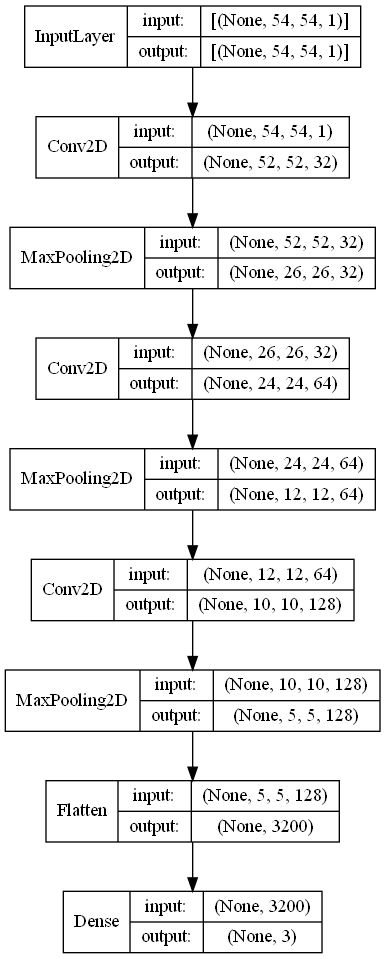

In [23]:
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [24]:
# Compile the model
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [25]:
# Train the model
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test), 
    epochs=80, 
    batch_size=32, 
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)]
)

Epoch 1/80
69/69 [==============================] - 6s 57ms/step - loss: 1.6362 - accuracy: 0.4478 - val_loss: 1.0237 - val_accuracy: 0.4755
Epoch 2/80
69/69 [==============================] - 3s 47ms/step - loss: 0.9706 - accuracy: 0.5404 - val_loss: 0.9474 - val_accuracy: 0.5318
Epoch 3/80
69/69 [==============================] - 3s 48ms/step - loss: 0.8809 - accuracy: 0.5957 - val_loss: 0.8812 - val_accuracy: 0.6152
Epoch 4/80
69/69 [==============================] - 3s 46ms/step - loss: 0.7794 - accuracy: 0.6711 - val_loss: 0.7827 - val_accuracy: 0.6697
Epoch 5/80
69/69 [==============================] - 3s 46ms/step - loss: 0.6932 - accuracy: 0.7164 - val_loss: 0.7240 - val_accuracy: 0.6679
Epoch 6/80
69/69 [==============================] - 3s 47ms/step - loss: 0.6857 - accuracy: 0.7219 - val_loss: 0.7113 - val_accuracy: 0.6878
Epoch 7/80
69/69 [==============================] - 3s 47ms/step - loss: 0.5819 - accuracy: 0.7641 - val_loss: 0.7074 - val_accuracy: 0.6915
Epoch 8/80
69

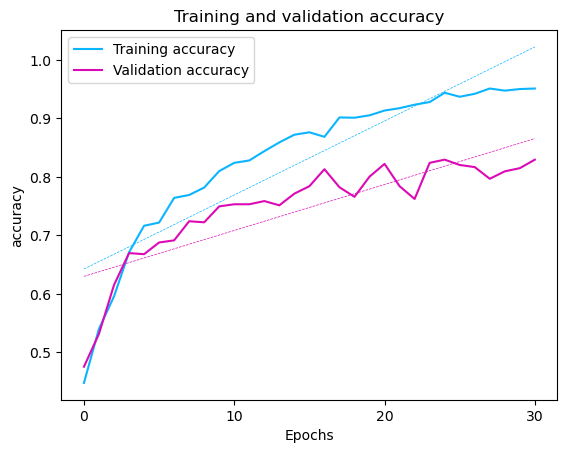

In [26]:
plot_training_history(history, metrics='accuracy')

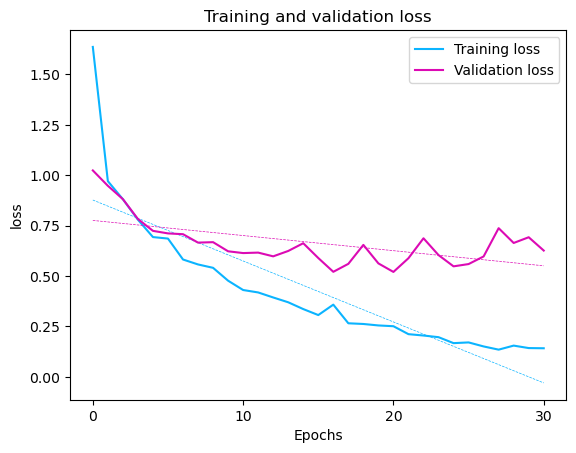

In [27]:
plot_training_history(history, metrics='loss')

### 2. LSTM

In [101]:
# Read the recordings
X, Y = [], []

# number of recordings to split one initial recording into
SPLIT_NUM = 1


label = 0
for directory in os.listdir(RECORDINGS_PATH):
    print(directory)
    for filename in os.listdir(os.path.join(RECORDINGS_PATH, directory)):
        full_path = os.path.join(RECORDINGS_PATH, directory, filename)
        # Read the csv file
        sensor_positions, sensor_reading, time = read_csv(full_path)
        # Reduce one dimension
        sensor_reading = np.squeeze(sensor_reading)
        
        # Split the recording into multiple ones
        sensor_readings = np.array_split(sensor_reading, SPLIT_NUM)
        for reading in sensor_readings:
            # Add the data to the lists
            X.append(reading)
            Y.append(label)
    label += 1

cuboid
cylinder
sphere


In [102]:
# Normalize the data
X = np.array(X)
print('Shape of the data (num_recordings, num_frames, num_sensors): ', X.shape)

Y = np.array(Y)
Y = to_categorical(Y)
print('Shape of the labels: ', Y.shape)

# Instantiate the scaler
scaler = StandardScaler()

# Scale the data
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

Shape of the data (num_recordings, num_frames, num_sensors):  (81, 50, 144)
Shape of the labels:  (81, 3)


In [103]:
# Data augmentation
# Add noise to the data to create more recordings
noise = np.random.normal(0, 0.1, X.shape)
X_aug = X + noise
Y_aug = Y

# Concatenate the original data with the augmented data
X = np.concatenate((X, X_aug))
Y = np.concatenate((Y, Y_aug))

In [104]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
print('Train', y_train.shape[0], 'recordings : Test', y_test.shape[0], 'recordings')

Train 129 recordings : Test 33 recordings


### Create the LSTM model

In [105]:
# Set the hyperparameters
epochs = 120
batch_size = 16
units = 60
dropout_rate = 0.2
reg_lambda = 0.001  # Regularization factor

model = Sequential()

# 1st block
# Add the first LSTM layer
model.add(LSTM(
    units=units, 
    input_shape=(X.shape[1], X.shape[2]),
    kernel_regularizer=regularizers.l2(reg_lambda)
))

# Add the dropout layer
model.add(Dropout(dropout_rate))

model.add(Dense(
    units=units, 
    activation='relu', 
    kernel_regularizer=regularizers.l2(reg_lambda))
)

model.add(Dense(units=Y.shape[1], activation='softmax'))

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 60)                49200     
                                                                 
 dropout_10 (Dropout)        (None, 60)                0         
                                                                 
 dense_22 (Dense)            (None, 60)                3660      
                                                                 
 dense_23 (Dense)            (None, 3)                 183       
                                                                 
Total params: 53043 (207.20 KB)
Trainable params: 53043 (207.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


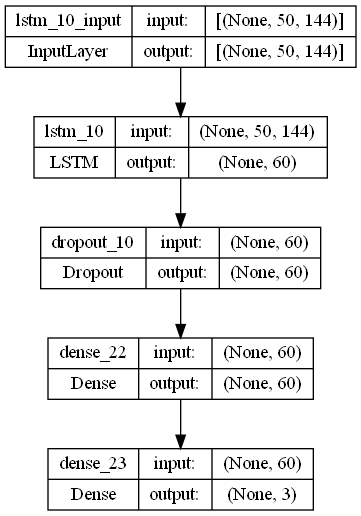

In [106]:
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [107]:
# Compile the model
model.compile(
    # Cross-Validation
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
print(Y.shape)
print(X.shape)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

(162, 3)
(162, 50, 144)


In [108]:
# Train the model
history = model.fit(
    X_train, y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping])

Epoch 1/120
9/9 [==============================] - 3s 74ms/step - loss: 1.2854 - accuracy: 0.4806 - val_loss: 1.2784 - val_accuracy: 0.3636
Epoch 2/120
9/9 [==============================] - 0s 19ms/step - loss: 1.1197 - accuracy: 0.6202 - val_loss: 1.2126 - val_accuracy: 0.5152
Epoch 3/120
9/9 [==============================] - 0s 19ms/step - loss: 1.0087 - accuracy: 0.7132 - val_loss: 1.1748 - val_accuracy: 0.5455
Epoch 4/120
9/9 [==============================] - 0s 19ms/step - loss: 0.9028 - accuracy: 0.7597 - val_loss: 1.1392 - val_accuracy: 0.5758
Epoch 5/120
9/9 [==============================] - 0s 20ms/step - loss: 0.8416 - accuracy: 0.7984 - val_loss: 1.0725 - val_accuracy: 0.6061
Epoch 6/120
9/9 [==============================] - 0s 19ms/step - loss: 0.7724 - accuracy: 0.8450 - val_loss: 1.0147 - val_accuracy: 0.6061
Epoch 7/120
9/9 [==============================] - 0s 19ms/step - loss: 0.6921 - accuracy: 0.8605 - val_loss: 0.9383 - val_accuracy: 0.6667
Epoch 8/120
9/9 [===

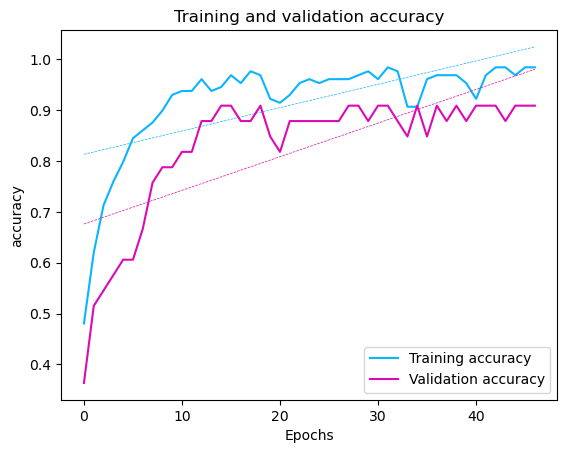

In [109]:
plot_training_history(history, metrics='accuracy')

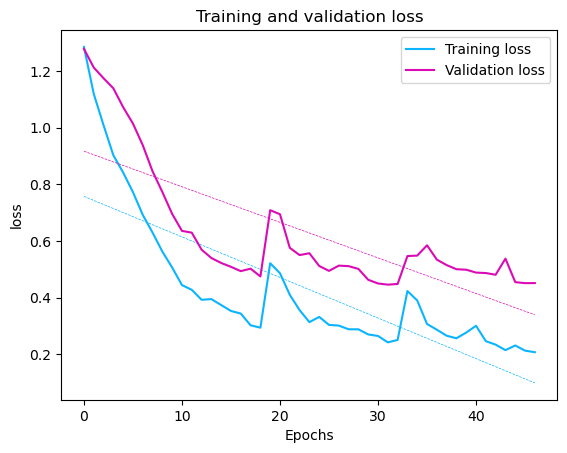

In [110]:
plot_training_history(history, metrics='loss')

### Investigating relationship between ral and artificial data

In [81]:
from model_testing.reading_manager import ReadingManager
from model_testing.lukas_handler import read_lukas_recording
import seaborn as sns

In [82]:
SHORT_RECORDINGS_PATH = "C:/Users/mjgoj/Documents/artificial_recordings/arm_data/short"

# Consists of recordings from the real arm
lukas_managers = {}

# List all the files in the directory
for filename in os.listdir(SHORT_RECORDINGS_PATH):
    full_path = os.path.join(SHORT_RECORDINGS_PATH, filename)
    label = filename.split('_')[0]
    sensor_positions, sensor_reading, time = read_lukas_recording(full_path)
    manager = ReadingManager(sensor_positions, sensor_reading, time)
    manager.identify_faulty_sensors()
    lukas_managers[manager] = label
    

In [83]:
maja_managers = {}

for directory in os.listdir(RECORDINGS_PATH):
    print(directory)
    for filename in os.listdir(os.path.join(RECORDINGS_PATH, directory)):
        full_path = os.path.join(RECORDINGS_PATH, directory, filename)
        # Read the csv file
        sensor_positions, sensor_reading, time = read_csv(full_path)
        manager = ReadingManager(sensor_positions, -sensor_reading, time)
        maja_managers[manager] = directory

cuboid
cylinder
sphere


In [110]:
def plot_multiple_recordings(_managers, indices=None, title=None):
    
    if indices is None:
        # Choose 6 different indices of recordings
        indices = np.random.choice(len(_managers), 6, replace=False)
    
    # Create subplots
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 12))
    palette = sns.color_palette("mako_r", 3)
    
    # Flatten the axes for easy iteration
    axes = axes.ravel()
    
    for i in range(6):
        # Get the correct reading manager
        _manager = list(_managers.keys())[indices[i]]
        reading_df = _manager.get_dataframe()
        sns.lineplot(
            data=reading_df,
            x='Time', y='Average',
            markers=True, color=palette[0],
            dashes=False, label='Average sensor output', linewidth=2.0,
            ax=axes[i]
        )
        # Add the standard deviation
        axes[i].fill_between(
            reading_df['Time'],
            reading_df['Average'] - reading_df['Std'],
            reading_df['Average'] + reading_df['Std'],
            alpha=0.2, color=palette[1], label='Standard deviation'
        )

        sns.lineplot(
            data=reading_df,
            x='Time', y='Max',
            markers=True, color=palette[2],
            dashes=False, label='Sensor with maximum output', linewidth=1.5,
            ax=axes[i]
        )
        
        # Set title for each subplot
        axes[i].set_title(f"Recording {indices[i]}")
        # Set common x and y labels for each subplot
        axes[i].set_xlabel("Time")
        axes[i].set_ylabel("Sensor Output")
        
        # Remove legend
        axes[i].legend().set_visible(False)
        
    # Create a unified legend for the entire figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.9, 1.05), fontsize='large')
    
    
    # Overall title for the entire figure
    if title is not None:
        fig.suptitle(title, fontsize=18, y=1.05)
        
    plt.tight_layout()
    plt.show()

24


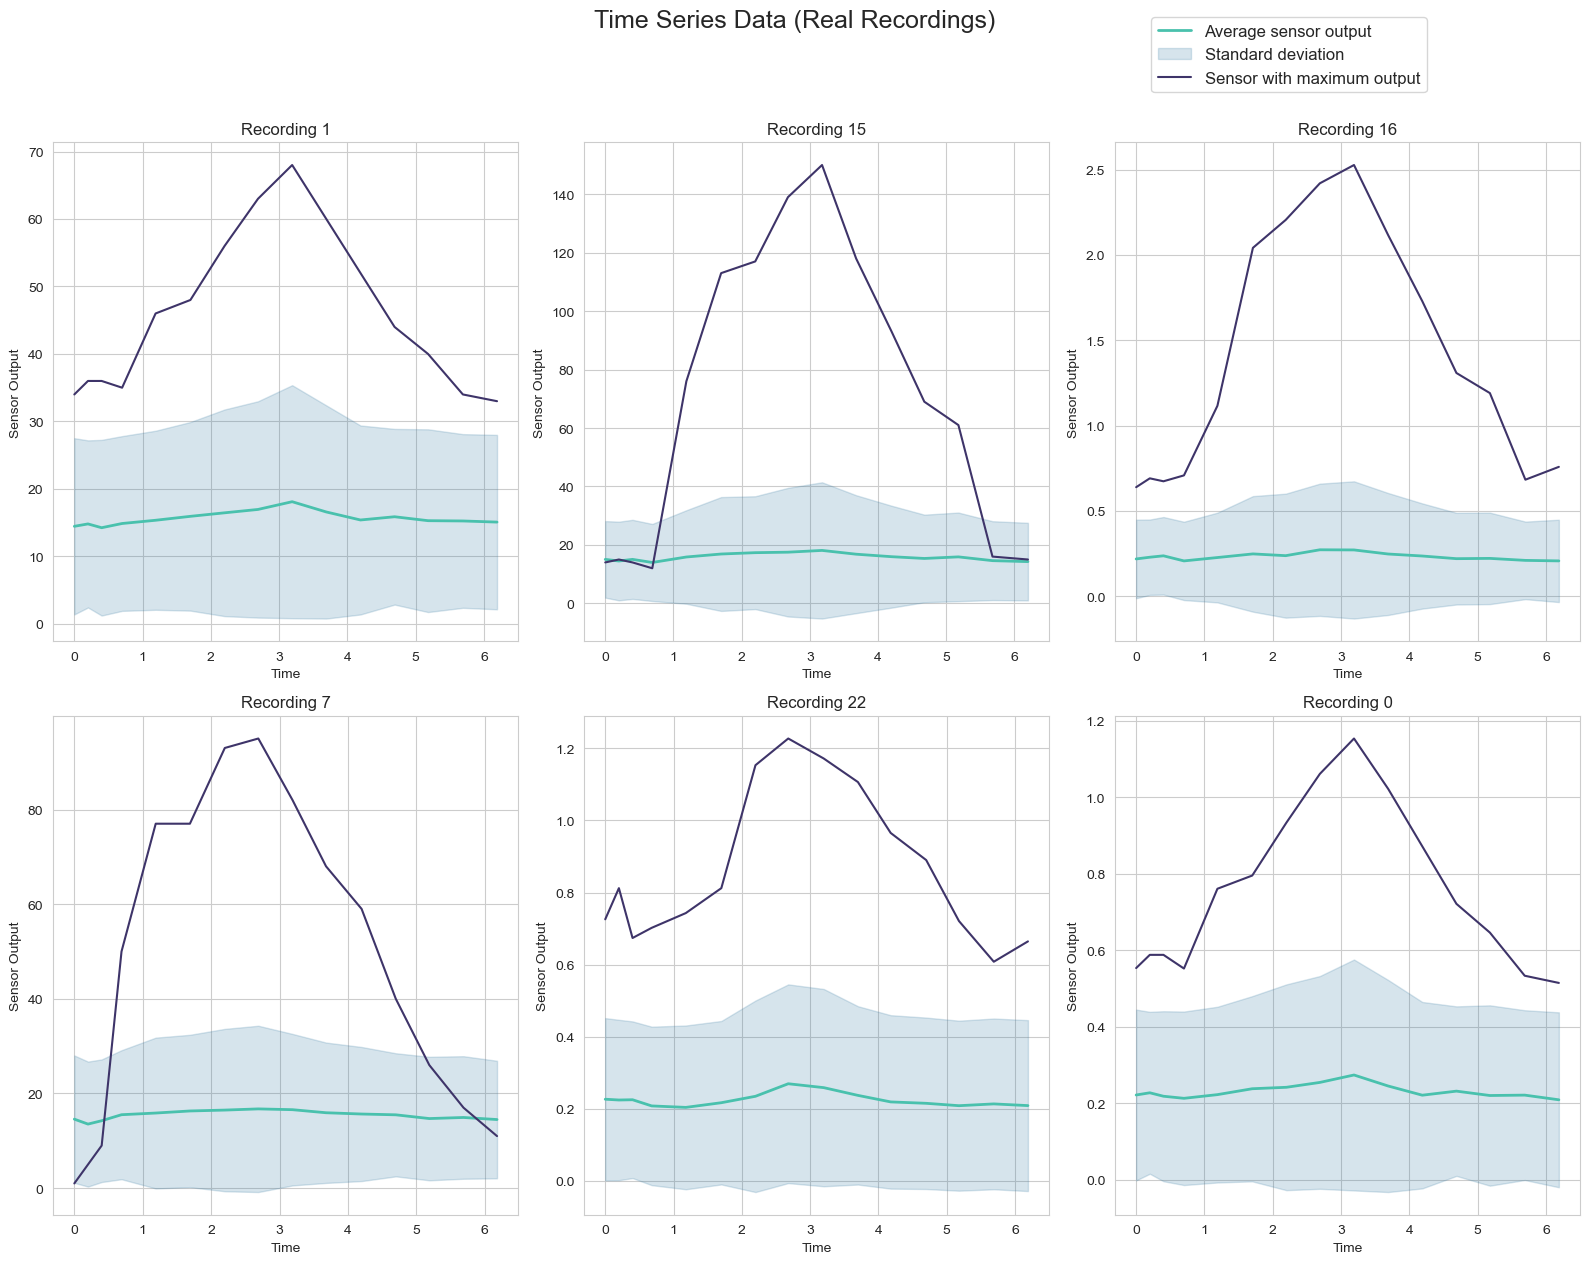

In [126]:
print(len(lukas_managers))
plot_multiple_recordings(
    lukas_managers, 
    title='Time Series Data (Real Recordings)'
)

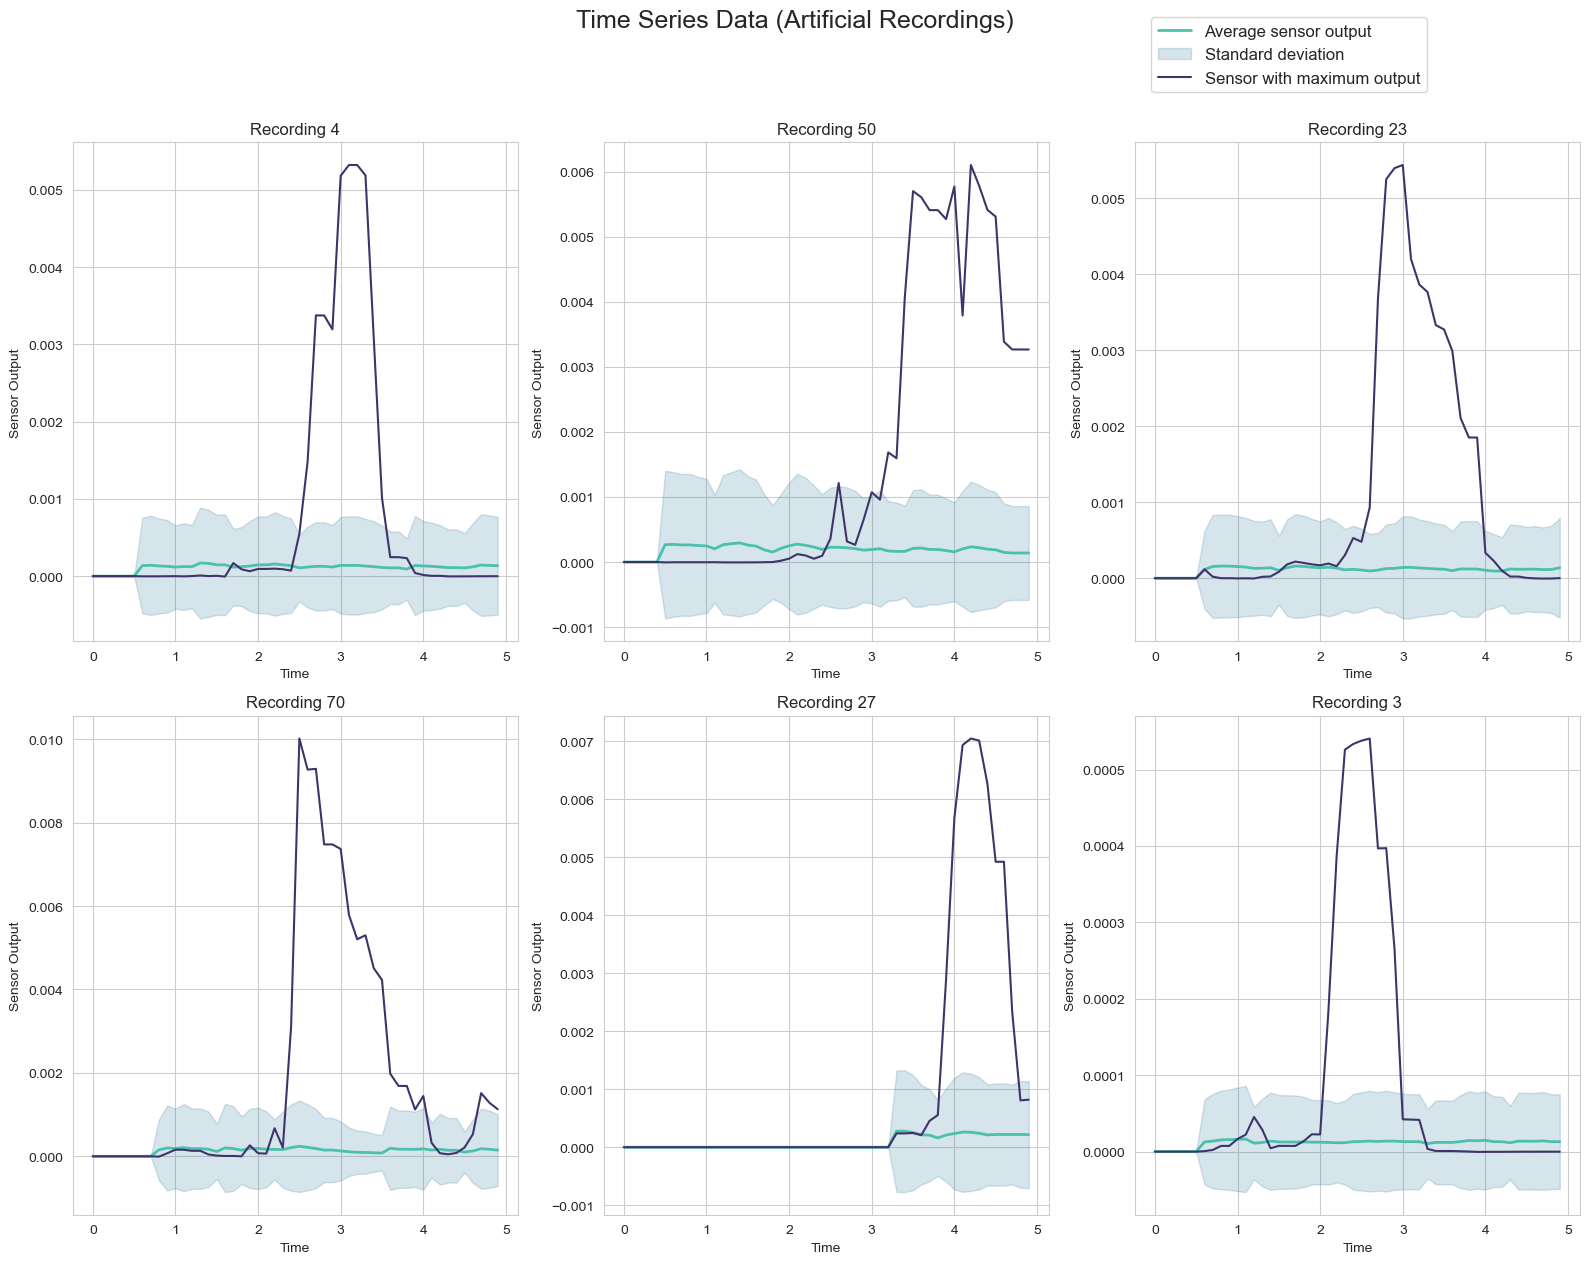

In [127]:
plot_multiple_recordings(
    maja_managers, 
    title='Time Series Data (Artificial Recordings)'
)